# Plants and Cars
## 1. Загрузка датасета:

Загрузка датасета с помощью Google Drive:

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # Для использования API GoogleDrive требуется авторизация через аккаунт Google
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
file_id = '1zBtt7-z1SWpX8vy1leHHSnuiEUtkGOGU' # id архива с данными на Google-диске
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/Dataset.zip')

In [3]:
# Распаковка архивов

!unzip -q /content/Dataset.zip -d /content/
!rm /content/Dataset.zip
!unzip -q /content/Dataset/data.zip -d /content/Dataset
!rm /content/Dataset/data.zip
!ls /content/Dataset

data  data.json


## 2. Подготовка данных к обучению:

In [4]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random

In [5]:
path = "/content/Dataset/"
json_path = path +"data.json"
with open(json_path,"r") as read_file:
  json_data = json.load(read_file) # загрузка содержимого json-файла с описаниями изображений

Просмотрев содержимое json-файла, можно заметить, что все растения обозначены именем категории 'Plants' и имеют id = 11. А все машины принадлежат категории 'Vehicles' и имеют id = 1, но не каждый объект, принадлежащий 'Vehicles' является машиной.

Поэтому необходимо рассмотреть подкатегории 'Vehicles', и выбрать среди них только те, которые являются машинами:

In [6]:
def get_subcategories(json_data, id): # функция, извлекающая все подкатегории категории с указанным id
  subcategories_set = set()
  for bundle in json_data:
    for item in json_data[bundle]:
      if ((item['category'] != None) and (item['category']['id'] == id)):
        subcategories_set.add((item['subcategory']['name'],item['subcategory']['id']))
  return subcategories_set

Применив функцию ```get_subcategories``` к растениям (id = 11), можно видеть, что все подкатегрии являются растениями (грибы 'Mushrooms', также включим в рассмотрение, но при желании их можно удалить):

In [7]:
plants_subcategories = get_subcategories(json_data, 11)
print(plants_subcategories)

{('Trees', 90), ('Сactus', 187), ('Moss', 189), ('Grass', 93), ('Mushrooms', 186), ('Home', 98), ('Aquatic plant', 188), ('Vegetables', 97), ('Flowers', 92), ('Bushes', 91), ('Tropical', 94)}


Применив функцию к машинам (id = 1), можно заметить, что подкатегории 'Aircrafts', 'Car Parts', 'Trains', 'Ships', 'SpaceShips', 'Spacecrafts' явно не являются машинами (для 'Car Parts' в том смысле, что её объекты не являются полноценной машиной).

In [8]:
cars_subcategories = get_subcategories(json_data, 1)
print(cars_subcategories)

{('Spacecrafts', 11), ('Aircrafts', 4), ('Car Parts', 147), ('Trucks', 2), ('Trains', 3), ('Busses', 7), ('SpaceShips', 5), ('Ships', 6), ('Electric Vehicles', 9), ('Cars', 1), ('Construction', 12)}


Исключим перечисленные выше подкатегории из рассмотрения, удалив их из списка подкатегорий 'Vehicles':

In [9]:
vehicles_id = {x[1] for x in cars_subcategories if not (x[0] in {'Aircrafts', 'Car Parts', 'Trains', 'Ships', 'SpaceShips', 'Spacecrafts'})}
print(vehicles_id) # вывод id подкатегорий, которые являются машинами

{1, 2, 7, 9, 12}


In [10]:
def get_data_names(path, json_data, vehicles_id): # функция, извлекающая из json-файла названия изображений, соотвествующих 
                                                  # машинам и растениям, и возвращающая их в виде списков cars и plants соответственно
  cars = []
  plants = []
  for bundle in json_data:
    for record in json_data[bundle]:
      if ((record['category'] != None) and (record['category']['id'] == 11)) or \
      ((record['category'] != None) and (record['category']['id'] == 1) and (record['subcategory'] != None) and (record['subcategory']['id'] in vehicles_id)):
        if record['category']['id'] == 1:
          cars.append(record['file'])
        else:
          plants.append(record['file'])
  return (cars, plants)

In [11]:
cars, plants = get_data_names(path, json_data, vehicles_id)

Разделим все полученные изображения на обучающую и тестовую выборки:

In [12]:
train_size = 0.8 # доля изображений, которые попадут в обучающую выборку
random_seed = 11

cars_train, cars_test, = train_test_split(cars, train_size=train_size, random_state=random_seed) # списки названий изображений для обучающей и тестовой выборок
plants_train, plants_test, = train_test_split(plants, train_size=train_size, random_state=random_seed)

In [13]:
def save_data(path, dataset_cl, items): # функция для извлечения изображений из папки data и формирования обучающего и тестового наборов данных
    for item in items:
      cmd = 'cp ' + os.path.join(path, item) + ' ' + path + dataset_cl
      os.system(cmd)

In [14]:
!rm -R /content/Dataset/Test
!rm -R /content/Dataset/Train

datasets = ['Train/', 'Test/']
classes = ['class0/', 'class1/'] # class0 - машины; class1 - растения

for dataset in datasets:
  os.mkdir(path + dataset)
  for cl in classes:
    os.mkdir(path + dataset + cl)

save_data(path,  datasets[0] + classes[0], cars_train)
save_data(path,  datasets[1] + classes[0], cars_test)
save_data(path,  datasets[0] + classes[1], plants_train)
save_data(path,  datasets[1] + classes[1], plants_test)

rm: cannot remove '/content/Dataset/Test': No such file or directory
rm: cannot remove '/content/Dataset/Train': No such file or directory


Выведем количество изображений, соответствующих обоим классам в обучающем и тестовом наборах данных:

In [15]:
!echo Обучающий набор, class0 и class1 соответственно:
!find /content/Dataset/Train/class0 -type f | wc -l
!find /content/Dataset/Train/class1 -type f | wc -l

!echo Тестовый набор, class0 и class1 соответственно:
!find /content/Dataset/Test/class0 -type f | wc -l
!find /content/Dataset/Test/class1 -type f | wc -l

Обучающий набор, class0 и class1 соответственно:
267
212
Тестовый набор, class0 и class1 соответственно:
67
53


## 3. Обучение модели:

In [16]:
import tensorflow as tf
from tensorflow import keras

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense

Воспользуемся генераторами для формирования батчей для обучения и аугментации данных:

In [17]:
# Для аугментации данных используем отражения по горизонтали, повороты,
# изменение масштаба и сдвиги вдоль горизонтальной и вертикальной осей

training_datagen = ImageDataGenerator(
  rescale = 1./255, # нормировка значений яркости
  horizontal_flip=True,
  fill_mode='nearest',
  rotation_range=15.0,
  zoom_range = 0.2,
  width_shift_range=0.2,
  height_shift_range=0.2)

In [18]:
WIDTH = 224 # Используемая для обучения модели имеет расширение (224x224)
HEIGHT = 224
batch_size = 32

data_dir = '/content/Dataset/Train/'
test_data_dir = '/content/Dataset/Test/'

train_generator = training_datagen.flow_from_directory(data_dir, target_size=(HEIGHT, WIDTH), batch_size=batch_size)
test_generator = training_datagen.flow_from_directory(test_data_dir, target_size=(HEIGHT, WIDTH), batch_size=batch_size)

Found 479 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Пример сгенерированного изображения:

(224, 224, 3)
[0. 1.]


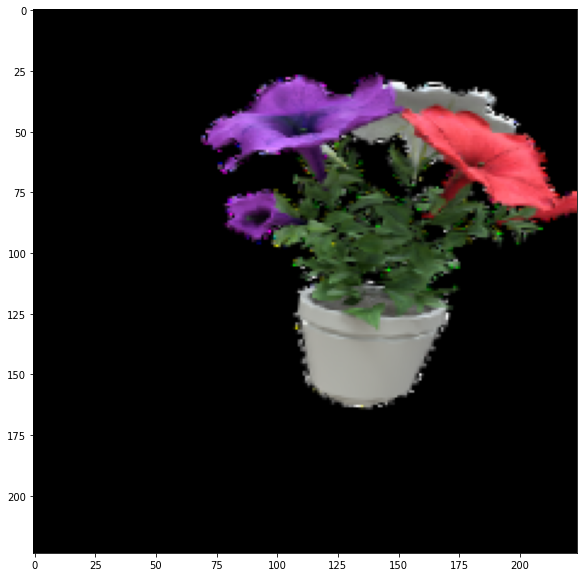

In [19]:
x,y = test_generator.next()
for i in range(0,1):
    image = x[i]
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.imshow(image, vmin = 0, vmax = 255)
    print(image.shape)
    print(y[i])

В качестве модели классификатора воспользуемся свёрточной сетью MobileNetV3 с весами, предобученными на датасете ImageNet.


Так как в данной задаче имеем всего 2 класса (а не 1000, как у ImageNet), удалим последний полносвязный слой модели, и заменим его двумя новыми слоями: предпоследний с 8 нейронами и ReLU-активацией и последний с двумя нейронами и softmax на выходе.


Все слои, кроме добавленных, "заморозим", чтобы их веса не изменялись в процессе обучения:

In [20]:
my_model = keras.models.Sequential()

pretrained_model = tf.keras.applications.MobileNetV3Large(input_shape=(HEIGHT, WIDTH, 3), alpha=0.75, include_top=False,
                                                          weights='imagenet', classes=2, pooling='avg', include_preprocessing=False)

for layer in pretrained_model.layers:
        layer.trainable=False

my_model.add(pretrained_model)
my_model.add(Flatten())
my_model.add(Dense(8, activation='relu'))
my_model.add(Dense(2, activation='softmax'))

my_model.summary()

7938048/7929688 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 720)              1808736   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 8)                 5768      
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,814,522
Trainable params: 5,786
Non-trainable params: 1,808,736
_________________________________________________________________


Таким образом, имеем 1442 обучаемых параметра.

При объёме обучающей выборки в 479 изображений и с учётом аугментации, можно рассчитывать, что переобучения не будет, т. к. обычно рекомендуется использовать обучающей набор, объём которого примерно в 30 раз больше кол-ва обучаемых параметров модели.

Для сохранения наилучшего результата за все эпохи обучения воспользуемся чекпоинтами с условием сохранения при достижении наибольшего значения метрик на тестовом наборе данных:

In [21]:
best_w_acc = keras.callbacks.ModelCheckpoint('best_result_acc.h5', # сохранение весов, обеспечивающих наибольшую точность
                                    monitor='val_accuracy',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto')



last_w = keras.callbacks.ModelCheckpoint('last_result.h5', # сохранение весов последней пройденной эпохи
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto')


callbacks = [best_w_acc, last_w]

In [22]:
# Для обучения используем метод Adam со стандартными значениями параметров:
my_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])

In [23]:
# Размер батча выберем равным 32, кол-во эпох обучения, равным 50
history = my_model.fit(train_generator, batch_size=32, validation_data=test_generator, epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50
15/15 [==============================] - 27s 862ms/step - loss: 0.2454 - accuracy: 0.9729 - auc: 0.9980 - val_loss: 0.0950 - val_accuracy: 0.9833 - val_auc: 0.9993
Epoch 2/50
15/15 [==============================] - 10s 675ms/step - loss: 0.0533 - accuracy: 0.9937 - auc: 0.9999 - val_loss: 0.0533 - val_accuracy: 0.9917 - val_auc: 0.9967
Epoch 3/50
15/15 [==============================] - 10s 699ms/step - loss: 0.0191 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9917 - val_auc: 0.9995
Epoch 4/50
15/15 [==============================] - 10s 648ms/step - loss: 0.0117 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9917 - val_auc: 0.9999
Epoch 5/50
15/15 [==============================] - 10s 651ms/step - loss: 0.0098 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9917 - val_auc: 0.9999
Epoch 6/50
15/15 [==============================] - 10s 658ms/step - loss: 0.0072 - accuracy: 1.0000 - auc: 1.0000 - val_loss

Графики функции потери и точности предсказания на обучающем и тестовом наборах:

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


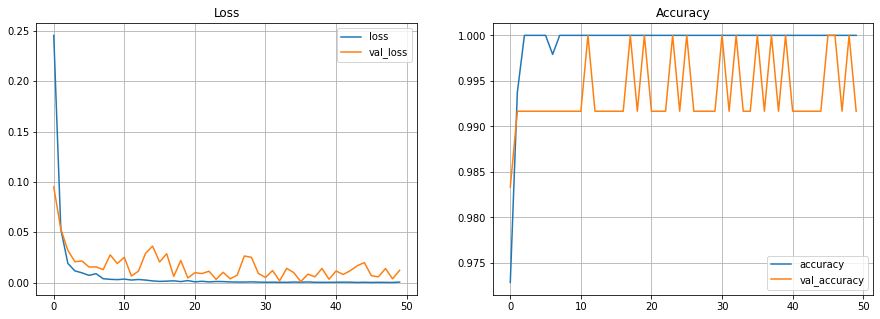

In [24]:
print(history.history.keys())

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].grid()
ax[0].set(title='Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].grid()
ax[1].set(title='Accuracy')
ax[1].legend()

## 4. Тестирование модели и оценка качества:

In [62]:
# Чтобы не обучать сеть при повторном запуске, можно загрузить веса с Google-диска
file_id = '1n2QOIhbKzqVShPqQb5EJ726GMPhSbInD'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/best_result_acc.h5')

In [63]:
# Загрузка весов, обеспечивающих наибольшую точность предсказания

my_model.load_weights('best_result_acc.h5')

In [65]:
# Оценка метрик модели на тестовом наборе данных

my_model.evaluate(test_generator)

4/4 [==============================] - 2s 449ms/step - loss: 0.0337 - accuracy: 0.9917 - auc: 0.9997


[0.0336594320833683, 0.9916666746139526, 0.9996527433395386]

Получим матрицу ошибок обученной модели для класса 0 - 'машины', а также построим ROC-кривую:

In [27]:
def get_data(path): # Функция для получения изображений из папки Test и меток для них
  images_names = []
  labels = []
  classes = ['class0/', 'class1/']
  for item in classes:
    images_names += [item + x for x in os.listdir(path + item)]
  images = []
  for name in images_names:
    img = cv2.imread(path + name)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    images.append(img / 255.0)
    if name.split('/')[0] == 'class0':
      labels.append(0)
    else:
      labels.append(1)
  return (np.array(images), labels)

In [28]:
(images, labels) = get_data(path + 'Test/') # Получаем все тестовые изображения и их метки
pred_labels = [np.argmax(x) for x in my_model.predict(images)] # Предсказание сети для тестовых изображений

In [30]:
TP = 0 # True-Positive количество объектов являющихся машинами, и правильно классифицированных сетью
FN = 0 # False-Negative количество объектов являющихся машинами, и неправильно классифицированных сетью
FP = 0 # False-Positive количество объектов не являющихся машинами, и неправильно классифицированных сетью (классифицированных как машины)
TN = 0 # True-Negative количество объектов не являющихся машинами, и правильно классифицированных сетью (классифицированных как растения)

for i in range(len(pred_labels)):
  if (pred_labels[i] == 0) and (labels[i] == 0):
    TP += 1
  elif (pred_labels[i] == 1) and (labels[i] == 0):
    FN += 1
  elif (pred_labels[i] == 0) and (labels[i] == 1):
    FP += 1
  elif (pred_labels[i] == 1) and (labels[i] == 1):
    TN += 1

print('Матрица ошибок класса 0 (машины):\n', np.array([[TP, FN],[FP, TN]]))

Матрица ошибок класса 0 (машины):
 [[66  1]
 [ 0 53]]


Рассмотрев матрицу ошибок для класса 0, можно видеть, что обученная сеть ошиблась лишь в 1 случае из 120.

Хотя следует отметить, что и машины на данном изображении, на котором происходит ошибка (cc30a7ee-a338-4041-8463-26c4bbe43413.png), несколько грузовиков стоят в анфас, что является редкостью для рассматриваемого набора данных, т. е. подобных изображений среди рассматриваемых практически не встречается.

Данная проблема решается расширением обучающей выборки соотвествующими примерами и не критична.

Так в данной задаче рассматриваются изображения только двух классов, то матрица ошибок для класса 1 может быть получена с помощью перестановки значений на главной диагонали матрицы ошибок класса 0, т. е. имеет вид: $ [[53, 0], [1, 66]] $.

Построим ROC-кривую для данной модели:

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Можно видеть, что площадь под кривой очень близка к 1 ($AUC \approx 0.99254$), что свидетельствует о высоком отношении числа верных предсказаний, к числу "пропусков":

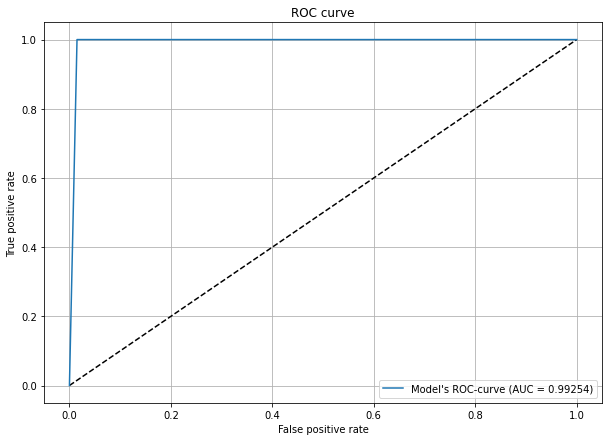

In [32]:
fpr, tpr, _ = roc_curve(labels, pred_labels)
auc_keras = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="Model's ROC-curve (AUC = {:.5f})".format(auc_keras))
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Пример работы модели на изображениях из тестовой выборки (вероятности принадлежности к классам 0 и 1 выводятся в виде вектора):

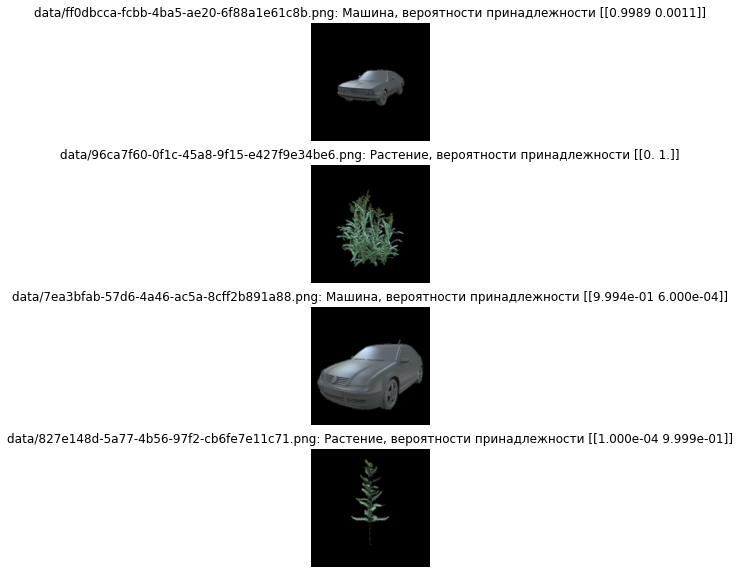

In [60]:
test_dataset = cars_test + plants_test

N = 4
random_imgs = random.sample(test_dataset,N)

dim = (224, 224)
plt.figure(figsize=(10, 10))
for i in range(N):
  img = cv2.imread(path + random_imgs[i])
  ax = plt.subplot(4, 1, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  exp_img = np.expand_dims(resized_img, axis = 0)
  label = my_model.predict(exp_img / 255.)
  if (np.argmax(label) == 0):
    plt.title(random_imgs[i] + ': ' + "Машина, вероятности принадлежности " + str(np.round(label,4)))
  else:
    plt.title(random_imgs[i] + ': ' + "Растение, вероятности принадлежности " + str(np.round(label,4)))
  plt.axis("off")

Пример работы модели на произвольном выбранном изображении:

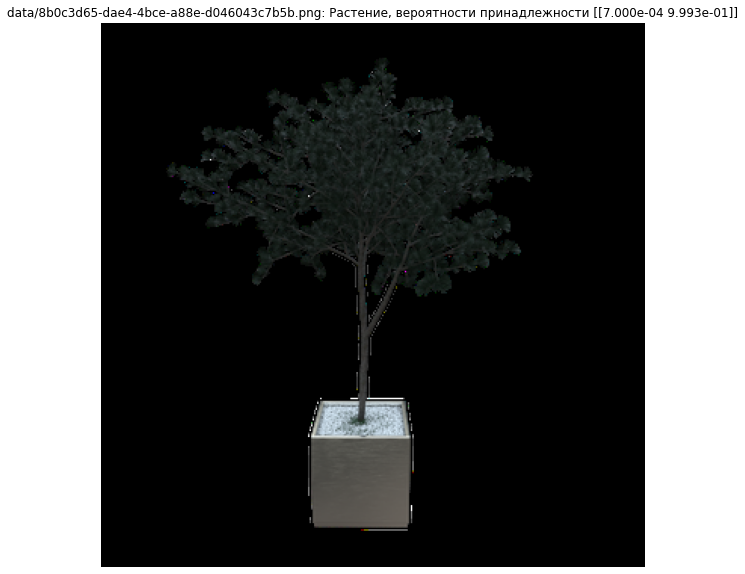

In [61]:
file_name = 'data/8b0c3d65-dae4-4bce-a88e-d046043c7b5b.png' 

img = cv2.imread(path + file_name) # path + file_name - путь к изображению, которое необходимо классифицировать
resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) # приведения размеров изображения к размерам входа сети (224 x 224)
exp_img = np.expand_dims(resized_img, axis = 0)
label = my_model.predict(exp_img / 255.)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

if (np.argmax(label) == 0):
  plt.title(file_name + ': ' + "Машина, вероятности принадлежности " + str(np.round(label,4)))
else:
  plt.title(file_name + ': ' + "Растение, вероятности принадлежности " + str(np.round(label,4)))
plt.axis("off");